# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) seeks to group data into clusters based on their properties and then allow us to predict which cluster a new member belongs.

We'll use a dataset generator that is part of [scikit-learn](https://scikit-learn.org/stable/index.html) called [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).  This generates data that falls into 2 different sets with a shape that looks like half-moons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
def generate_data():
    xvec, val = datasets.make_moons(200, noise=0.2)

    # encode the output to be 2 elements
    x = []
    v = []
    for xv, vv in zip(xvec, val):
        x.append(np.array(xv))
        v.append(vv)

    return np.array(x), np.array(v)

In [5]:
x, v = generate_data()

Let's look at a point and it's value

In [6]:
print(f"x = {x[0]}, value = {v[0]}")

x = [ 1.70465161 -0.28009917], value = 1


Now let's plot the data

In [7]:
def plot_data(x, v):
    xpt = [q[0] for q in x]
    ypt = [q[1] for q in x]

    fig, ax = plt.subplots()
    ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")
    ax.set_aspect("equal")
    return fig

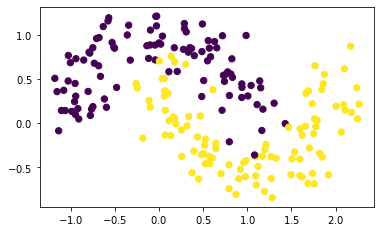

In [8]:
fig = plot_data(x, v)

We want to partition this domain into 2 regions, such that when we come in with a new point, we know which group it belongs to.

First we setup and train our network

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop

2023-04-10 11:59:53.413113: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 11:59:53.414630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 11:59:53.445045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 11:59:53.445713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 11:59:54.050108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [10]:
model = Sequential()
model.add(Dense(50, input_dim=2, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [11]:
rms = RMSprop()
model.compile(loss='binary_crossentropy',
              optimizer=rms, metrics=['accuracy'])

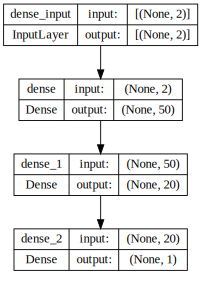

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

We seem to need a lot of epochs here to get a good result

In [97]:
epochs = 100
results = model.fit(x, v, batch_size=50, epochs=epochs)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.9300
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1910 - accuracy: 0.9350
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9350
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1905 - accuracy: 0.9350
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1889 - accuracy: 0.9350
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1866 - accuracy: 0.9350
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9350
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.9350
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1810 - accuracy: 0.9400
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9350
Epoch 11/100
4/4 [===========

In [98]:
score = model.evaluate(x, v, verbose=0)
print(f"score = {score[0]}")
print(f"accuracy = {score[1]}")

score = 0.10588617622852325
accuracy = 0.949999988079071


Let's look at a prediction.  We need to feed in a single point as an array of shape `(N, 2)`, where `N` is the number of points

In [99]:
res = model.predict(np.array([[-2, 2]]))
res

1/1 [==============================] - 0s 17ms/step


array([[4.807813e-18]], dtype=float32)

We see that we get a floating point number.  We will need to convert this to 0 or 1 by rounding.

Let's plot the partitioning

In [100]:
M = 128
N = 128

xmin = -1.75
xmax = 2.5
ymin = -1.25
ymax = 1.75

xpt = np.linspace(xmin, xmax, M)
ypt = np.linspace(ymin, ymax, N)

To make the prediction go faster, we want to feed in a vector of these points, of the form:
```
[[xpt[0], ypt[0]],
 [xpt[1], ypt[1]],
 ...
]
```

We can see that this packs them into the vector

In [101]:
pairs = np.array(np.meshgrid(xpt, ypt)).T.reshape(-1, 2)
pairs[0]

array([-1.75, -1.25])

Now we do the prediction.  We will get a vector out, which we reshape to match the original domain.

In [102]:
res = model.predict(pairs, verbose=0)
res.shape = (M, N)

Finally, round to 0 or 1

In [103]:
domain = np.where(res > 0.5, 1, 0)

and we can plot the data

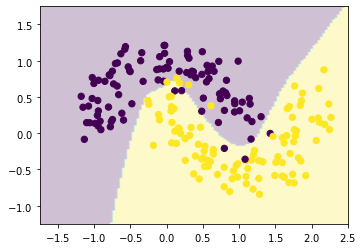

In [104]:
fig, ax = plt.subplots()
ax.imshow(domain.T, origin="lower",
          extent=[xmin, xmax, ymin, ymax], alpha=0.25)
xpt = [q[0] for q in x]
ypt = [q[1] for q in x]

ax.scatter(xpt, ypt, s=40, c=v, cmap="viridis")